In [1]:
import pandas as pd
import pandas_ta as ta
import quantstats as qs
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


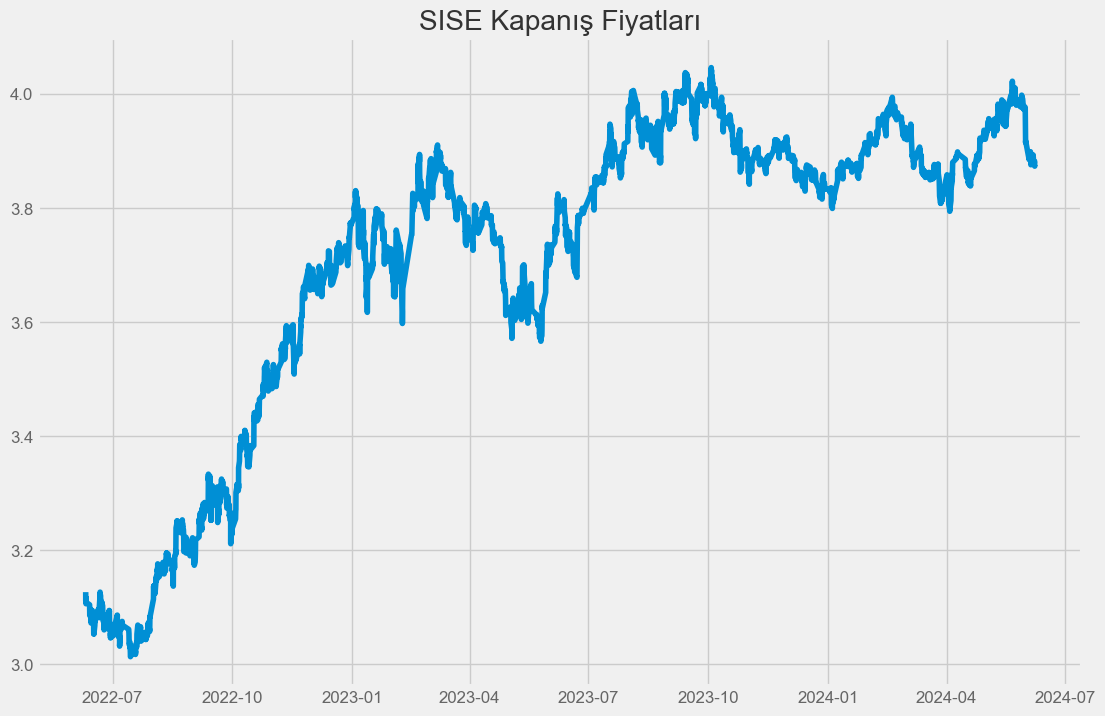

In [2]:
data=yf.download(tickers="SISE.IS",interval="1h",start="2022-06-10")
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("SISE Kapanış Fiyatları")
plt.plot(np.log(data["Adj Close"]))


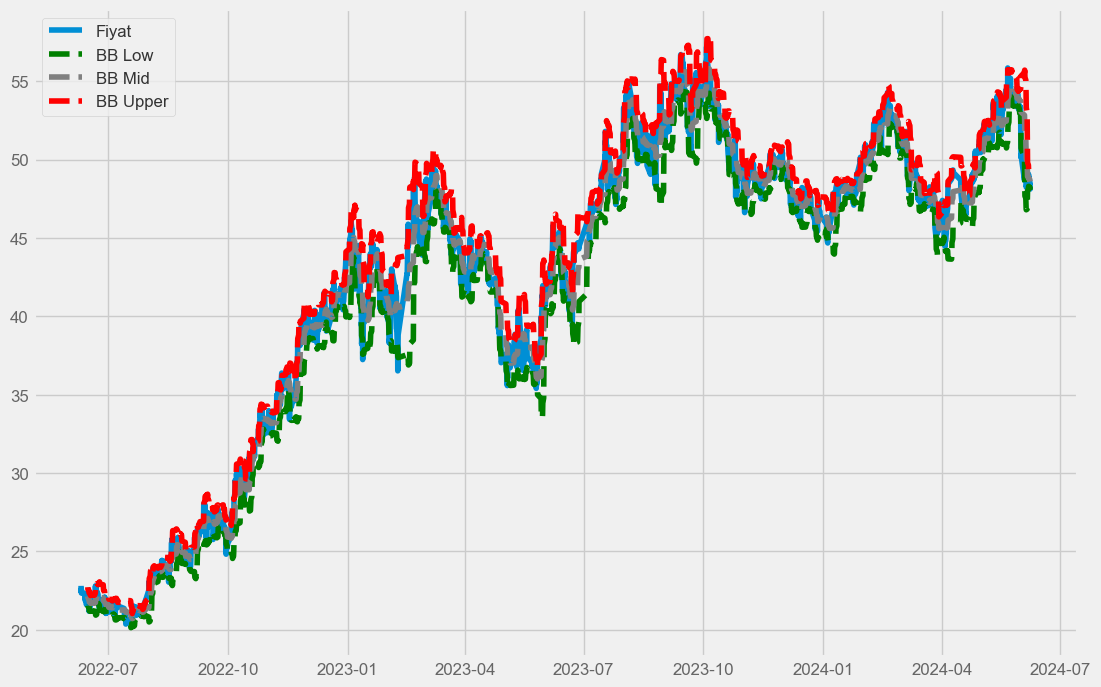

In [154]:
data["BB Low"]=ta.bbands(data["Adj Close"],29,2).iloc[:,0]
data["BB Mid"]=ta.bbands(data["Adj Close"],29,2).iloc[:,1]
data["BB Upper"]=ta.bbands(data["Adj Close"],29,2).iloc[:,2]
plt.figure(figsize=(12,8))
plt.plot(data["Adj Close"],label="Fiyat")
plt.plot(data["BB Low"],"--",color="green",label="BB Low")
plt.plot(data["BB Mid"],"--",color="gray",label="BB Mid")
plt.plot(data["BB Upper"],"--",color="red",label="BB Upper")
plt.legend()

In [155]:
def apply_strategy(df):
    df['Buy Signal'] = np.where((df['Adj Close'] < df['BB Low']) & (df["Adj Close"].shift(1)>df["BB Low"]), 1, 0)
    df['Sell Signal'] = np.where((df['Adj Close'] > df['BB Upper']) & (df["Adj Close"].shift(1)<df["BB Upper"].shift(1)), 1, 0)
    df['Position'] = 0

    position = 0
    for i in range(1, len(df)):
        if df['Buy Signal'][i] == 1 and position == 0:
            df['Position'][i] = 1
            position = 1
        elif df['Sell Signal'][i] == 1 and position == 1:
            df['Position'][i] = -1
            position = 0
        else:
            df['Position'][i] = df['Position'][i-1]


    return df
data=apply_strategy(data)

In [156]:
def calculate_strategy_returns(df):
    df['Strategy Returns'] = 0
    buy_price = 0

    for i in range(1, len(df)):
        if ((df['Buy Signal'][i] == 1) & (buy_price==0)):
            buy_price = df['Adj Close'][i]
        elif df['Sell Signal'][i] == 1 and buy_price != 0:
            df['Strategy Returns'][i] = ((df['Adj Close'][i] - buy_price) / buy_price)*100
            buy_price = 0

    return df


data = calculate_strategy_returns(data)
total_returns = data['Strategy Returns'].sum()
total_returns

112.70877783223915

<Axes: xlabel='Datetime'>

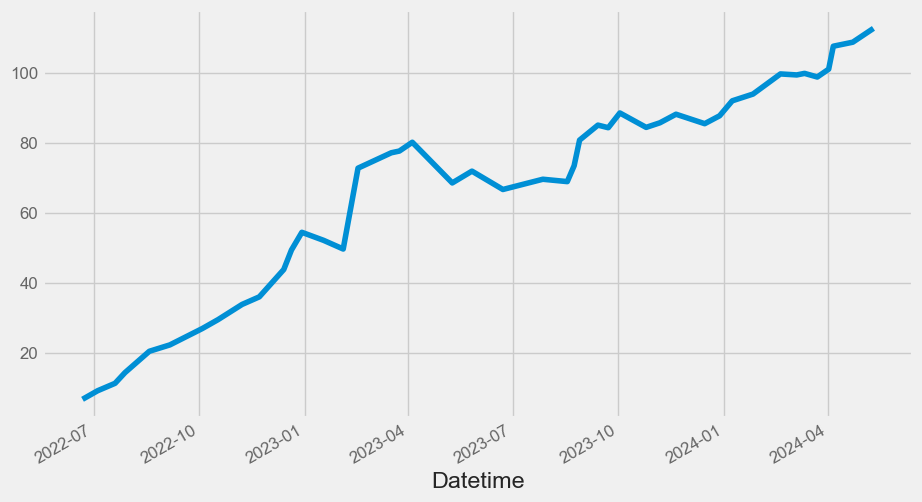

In [160]:
data[data["Strategy Returns"]!=0]["Strategy Returns"].cumsum().plot()

In [151]:
sonuçlar=pd.DataFrame(columns=["MA","std","Kar"])
mas=[]
stds=[]
karlar=[]
for ma in range(5,101):
       data["BB Low"]=ta.bbands(data["Adj Close"],ma,2).iloc[:,0]
       data["BB Mid"]=ta.bbands(data["Adj Close"],ma,2).iloc[:,1]
       data["BB Upper"]=ta.bbands(data["Adj Close"],ma,2).iloc[:,2]
       data=apply_strategy(data)
       data = calculate_strategy_returns(data)
       total_returns = data['Strategy Returns'].sum()
       mas.append(ma)
       karlar.append(total_returns)
       print("MA:{} Kar:{}".format(ma,total_returns))

sonuçlar["MA"]=mas
sonuçlar["std"]=stds
sonuçlar["Kar"]=karlar


MA:5 Kar:0
MA:6 Kar:64.42762276904261
MA:7 Kar:63.93418393361538
MA:8 Kar:23.077254065146136
MA:9 Kar:50.534508193761056
MA:10 Kar:75.34617185583835
MA:11 Kar:75.07930590635779
MA:12 Kar:76.89532118667866
MA:13 Kar:85.65261284371098
MA:14 Kar:90.60850737261752
MA:15 Kar:76.50438605378508
MA:16 Kar:70.81162979181826
MA:17 Kar:66.75588421922407
MA:18 Kar:79.77092539692629
MA:19 Kar:69.758933085001
MA:20 Kar:77.80425358758733
MA:21 Kar:67.13317449650285
MA:22 Kar:76.62089895651593
MA:23 Kar:88.87468076138731
MA:24 Kar:98.33443932810161
MA:25 Kar:96.46676799999449
MA:26 Kar:103.02260468804141
MA:27 Kar:110.64975108576294
MA:28 Kar:112.2428350804989
MA:29 Kar:112.70877783223915
MA:30 Kar:107.04276461141993
MA:31 Kar:88.17814246183737
MA:32 Kar:87.88785748769817
MA:33 Kar:96.84134042915775
MA:34 Kar:87.19129487740615
MA:35 Kar:90.49787482308801
MA:36 Kar:65.34410063410148
MA:37 Kar:55.52956735687487
MA:38 Kar:66.27102707063945
MA:39 Kar:64.05288015331445
MA:40 Kar:57.422748968177544
MA:41 Ka

In [153]:
sonuçlar.sort_values(by="Kar",ascending=False)

,MA,std,Kar
24,29,3,112.708778
23,28,3,112.242835
22,27,3,110.649751
25,30,3,107.042765
21,26,3,103.022605
...,...,...,...
93,98,3,40.713069
68,73,3,40.575705
69,74,3,39.743935
3,8,3,23.077254


[*********************100%%**********************]  1 of 1 completed


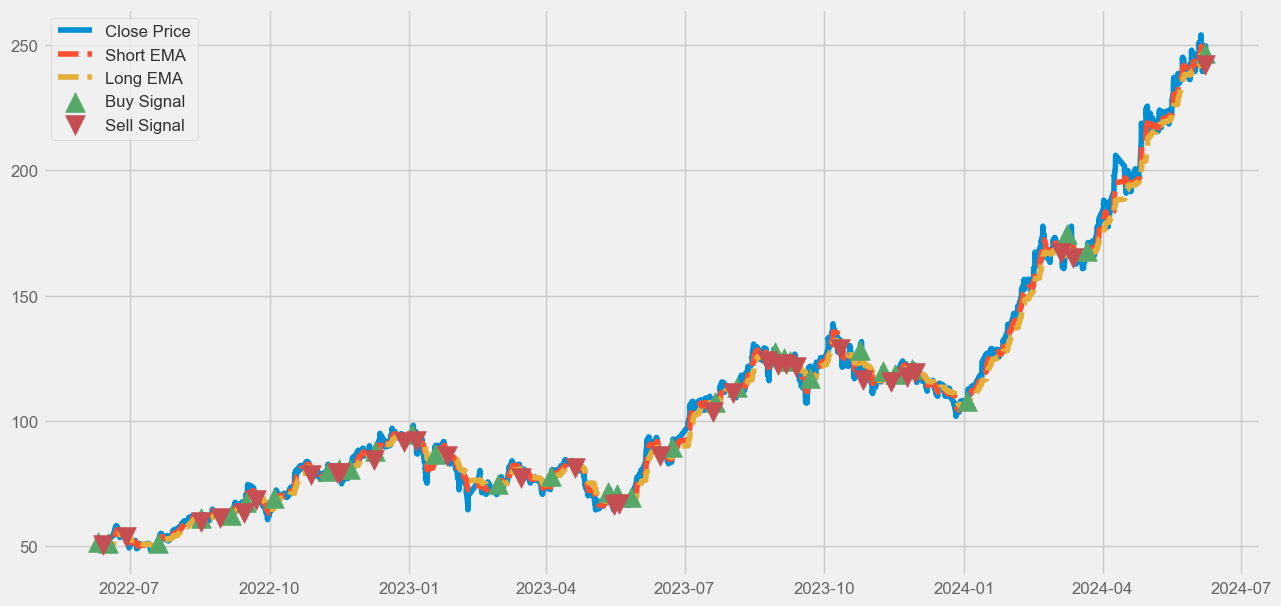

Total Strategy Returns: 162.88%


In [170]:
df=yf.download(tickers="TAVHL.IS",interval="1h",start="2022-06-10")
def compute_ema(df, short_window=20, long_window=50):
    df['Short EMA'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['Long EMA'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    return df

# Stratejiyi uygulama
def apply_trend_following_strategy(df):
    df['Buy Signal'] = np.where((df['Short EMA'] > df['Long EMA']) & (df['Short EMA'].shift(1) <= df['Long EMA'].shift(1)), 1, 0)
    df['Sell Signal'] = np.where((df['Short EMA'] < df['Long EMA']) & (df['Short EMA'].shift(1) >= df['Long EMA'].shift(1)), 1, 0)
    df['Position'] = 0

    position = 0
    for i in range(1, len(df)):
        if df['Buy Signal'][i] == 1:
            df['Position'][i] = 1
            position = 1
        elif df['Sell Signal'][i] == 1:
            df['Position'][i] = -1
            position = 0
        else:
            df['Position'][i] = df['Position'][i-1]

    return df

# Getirileri hesaplama
def calculate_strategy_returns(df):
    df['Strategy Returns'] = 0
    buy_price = 0

    for i in range(1, len(df)):
        if df['Buy Signal'][i] == 1:
            buy_price = df['Close'][i]
        elif df['Sell Signal'][i] == 1 and buy_price != 0:
            df['Strategy Returns'][i] = (df['Close'][i] - buy_price) / buy_price
            buy_price = 0

    return df

# Hesaplama ve stratejiyi uygulama
df = compute_ema(df)
df = apply_trend_following_strategy(df)
df = calculate_strategy_returns(df)

# Stratejinin backtest sonuçlarını görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Short EMA'], label='Short EMA', linestyle='--')
plt.plot(df['Long EMA'], label='Long EMA', linestyle='--')
plt.scatter(df[df['Buy Signal'] == 1].index, df[df['Buy Signal'] == 1]['Close'], label='Buy Signal', marker='^', color='g', alpha=1,s=200,zorder=3)
plt.scatter(df[df['Sell Signal'] == 1].index, df[df['Sell Signal'] == 1]['Close'], label='Sell Signal', marker='v', color='r', alpha=1,s=200,zorder=3)
plt.legend()
plt.show()

# Performans ölçümü
total_returns = df['Strategy Returns'].sum()
print(f'Total Strategy Returns: {total_returns * 100:.2f}%')

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import scipy.optimize as sco

# Hisse senetleri ve endeks
tickers = ['TAVHL.IS', 'BIMAS.IS', 'YKBNK.IS', 'AKGRT.IS', 'NTHOL.IS', 'AKSGY.IS', 'KCHOL.IS', 'ENJSA.IS', 'XU100.IS']
start_date = '2015-01-01'
end_date = '2023-01-01'

# Veri çekme
data = pdr.get_data_yahoo(tickers, start=start_date, end=end_date)['Adj Close']

# Günlük getirileri hesaplama
returns = data.pct_change().dropna()

# Piyasa getirisi olarak BIST 100 endeksini kullanıyoruz
market_returns = returns['XU100.IS']

# Ortalama getiriler ve kovaryans matrisi
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Black-Litterman parametreleri
# Örneğin, yatırımcıların görüşleri
P = np.zeros((5, len(tickers)))  # 5 görüş, her bir hisse için 9 hisse senedi
P[0, tickers.index('TAVHL.IS')] = 1  # TAVHL için görüş
P[1, tickers.index('BIMAS.IS')] = 1  # BIMAS için görüş
P[2, tickers.index('YKBNK.IS')] = 1  # YKBNK için görüş
P[3, tickers.index('AKGRT.IS')] = 1  # AKGRT için görüş
P[4, tickers.index('KCHOL.IS')] = 1  # KCHOL için görüş

Q = np.array([0.02, 0.03, 0.025, 0.015, 0.02])  # Görüşlere göre beklenen getiriler

# Görüşlerin güven düzeyi
omega = np.diag([0.0001, 0.0001, 0.0001, 0.0001, 0.0001])  # Basit bir varsayım

# Risk-free rate
rf = 0.01

# Pi (piyasa denge getirileri)
delta = 2.5  # Risk aversion coefficient
pi = delta * cov_matrix @ mean_returns

# Black-Litterman expected returns
M_inverse = np.linalg.inv(cov_matrix)
tau = 0.025
omega_inverse = np.linalg.inv(omega)
adjusted_mean_returns = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + P.T @ omega_inverse @ P) @ \
                        (np.linalg.inv(tau * cov_matrix) @ pi + P.T @ omega_inverse @ Q)

# Portföy optimizasyonu (Markowitz)
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    p_returns, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - rf) / p_volatility

def get_optimal_weights(mean_returns, cov_matrix, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

optimal_weights = get_optimal_weights(adjusted_mean_returns, cov_matrix, rf)
print("Optimal Portföy Ağırlıkları:")
print(optimal_weights)


AttributeError: 'NoneType' object has no attribute 'group'